# Bias Amplification by Quantitative Misrepresentation

This notebook guides you through the process of bias amplification by quantitative misrepresentation. This demonstration uses chest X-ray images from the Medical Imaging & Data Resource Center (MIDRC) Open-A1 data set as the example, and provides you with the instruction on how to train and deploy the model, as well as visualize the amplified bias.
Quantitative misrepresentation (i.e., data set skew) is systematically applied to the training set to simulate different levels of selection bias. Specifically, the data used during development are selected such that the disease prevalence varies between patient subgroups. The degree to which bias is promoted can be controlled by changing the degree to which the prevalence varies between subgroups.

## Sections

- [1. Data Download and Conversion](#data_download)\
Download required data set from MIDRC and convert *dicom* to *.png* files.
- [2. Data Partition](#data_partition)\
Partition data into training, validation and test sets.
- [3. Data preprocessing](#data_preprocessing)\
Preprocess training and validation data sets with levels of disease prevalence in different subgroups.
- [4. Model Training](#model_training)\
Train bias amplification models.
- [5. Model Inference](#model_inference)\
Deploy models on the independent test set.
- [6. Bias Visualization](#bias_visualization)\
Calculate metric and visualize model bias.

<a id='data_download'></a>
## 1. Data Download and Conversion

(**Please skip this step if you have already done**)The example uses MIDRC Open-A1 chest X-ray dataset ([MIDRC official website](https://data.midrc.org/)), which can be accessed and downloaded by following the instruction ([link for download instruction](https://data.midrc.org/dashboard/Public/documentation/Gen3_MIDRC_GetStarted.pdf)). Several *.tsv* files that include study case, patient demography and image information can also be downloaded from the website (for your convenience, we have already included them in this repository). After data is successfully downloaded, the script below will generate *.json* data summary file, and convert *dicom* files to *.png* files.
**Warning: This section may take 10+ hours to finish.**

In [4]:
# data summarization

# this is the directory where dicom data files are saved
data_dir = "/gpfs_projects/ravi.samala/DATA/MIDRC3/20221010_open_A1_CRDX_unzip"
# directory to save output summary file
output_file = "data/20221010_summary_table__open_A1.json" 
%run ../src/utils/data_summarize.py \
    -i "{data_dir}" \
    -c "data/20221010_open_A1_all_Cases.tsv" \
    -s "data/20221010_open_A1_all_Imaging_Series.tsv" \
    -o "{output_file}"
# convert dicom to png file
png_save_dir = "/gpfs_projects/yuhang.zhang/OUT/2022_CXR/open_a1_jpeg" # EDIT. directory to save png files
%run ../src/utils/data_conversion.py \
    --save_dir "{png_save_dir}" \
    --input_file "data/20221010_summary_table__open_A1.json"


Start image conversion to jpeg
input: 20221010_summary_table__open_A1.json

found 89502 image files
converting all images


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89502/89502 [01:29<00:00, 997.66it/s]



DONE



<a id='data_partition'></a>
## 2. Data Partition

After data are converted to *.png* files, they needed to be properly partitioned into training, validation and testing sets. In this experiment, all the data sets are equally stratified by patient sex (male and female), race (white and black) and COVID status (positive and negative). For each patient, only 1 image is selected. To accelerate the whole experiment process, only 50% of the entire Open-A1 dataset is used. 

In [5]:
# data partition
# EDIT. folder to save partitioning csv lists and conduct experiments
main_dir = "/gpfs_projects/yuhang.zhang/OUT/2022_CXR/juypter_direct_test"
conversion_file = png_save_dir + "/conversion_table.json"
%run ../src/utils/data_partitions.py \
    --input_list "20221010_summary_table__open_A1.json" \
    --conversion_file "{conversion_file}" \
    --test_size 0.3 \
    --validation_size 0.2 \
    --save_dir "{main_dir}" \
    --max_img_per_patient 1 \
    --tasks 'M' 'F' 'White' 'Black' 'Yes' 'No' \
    --patient_img_selection_mode "random" \
    --random_seed 2 \
    --subsample_rate 0.5

Beginning bootstrapping

Number of patients/subgroup in input summary:
| subgroup       |   count |
|:---------------|--------:|
| F-Black-No-CR  |     678 |
| F-Black-Yes-CR |    1913 |
| F-White-No-CR  |    2004 |
| F-White-Yes-CR |    1250 |
| M-Black-No-CR  |     658 |
| M-Black-Yes-CR |    1684 |
| M-White-No-CR  |    1864 |
| M-White-Yes-CR |    1333 |

By patient summary of data partition

| subgroup       |   independent_test |   train |   validation |   All |
|:---------------|-------------------:|--------:|-------------:|------:|
| F-Black-No-CR  |                 99 |     164 |           66 |   329 |
| F-Black-Yes-CR |                 99 |     164 |           66 |   329 |
| F-White-No-CR  |                 99 |     164 |           66 |   329 |
| F-White-Yes-CR |                 99 |     164 |           66 |   329 |
| M-Black-No-CR  |                 99 |     164 |           66 |   329 |
| M-Black-Yes-CR |                 99 |     164 |           66 |   329 |
| M-White-No-CR 

<a id='data_preprocessing'></a>
## 3. Data Preprocessing

To amplify the model bias by quantitative misrepresentation, the first step is to vary the disease prevalence within each subgroup in the **training set** while maintaining constant overall disease prevalence and subgroup distribution. 
This demonstration takes patient sex subgroup (male and female) as an example. You can run the following code to sample the disease prevalence to 0%, 25%, 50%, 75% and 100% in "F" (female) subgroup, while the disease prevalence in "M" (male) will be 100%, 75%, 50%, 25% and 0% respectively. Noted that training set with 50% disease prevalence in each subgroup serves as the baseline.
The code will save resulted training set *.csv* files and renamed with subgroup disease prevalence (e.g., training set with 25% disease prevalence in female subgroup will be saved as *25FP_train.csv*).

In [6]:
# manipulate subgroup disease prevalence in training/validation set
%run ../src/utils/quantitative_misrepresentation_data_process.py \
    --input_file "train.csv" \
    --prevalences 0 0.25 0.5 0.75 1 \
    --test_subgroup "F" \
    --in_dir "{main_dir}" \
    --save_dir "{main_dir}"
%run ../src/utils/quantitative_misrepresentation_data_process.py \
    --input_file "validation.csv" \
    --prevalences 0 0.25 0.5 0.75 1 \
    --test_subgroup "F" \
    --in_dir "{main_dir}" \
    --save_dir "{main_dir}"

Start data sampling with prevalence of 0.0 for F in train.csv
Start data sampling with prevalence of 0.25 for F in train.csv
Start data sampling with prevalence of 0.5 for F in train.csv
Start data sampling with prevalence of 0.75 for F in train.csv
Start data sampling with prevalence of 1.0 for F in train.csv
Start data sampling with prevalence of 0.0 for F in validation.csv
Start data sampling with prevalence of 0.25 for F in validation.csv
Start data sampling with prevalence of 0.5 for F in validation.csv
Start data sampling with prevalence of 0.75 for F in validation.csv
Start data sampling with prevalence of 1.0 for F in validation.csv


<a id='model_training'></a>
## 4. Model Training

After data preprocessing is done, you can run the following cell to train models with these different training sets. In this demonstration we use *ResNet-18* as the example network architecture, and pre-trained weights trained from a contrastive
self-supervised learning (CSL) approach and data from the CheXpert data. This weight file can be found under *example/* directory.

In [7]:
# model training
exp_list = ["0FP", "25FP", "50FP", "75FP", "100FP"]
for exp in exp_list:
    %run ../src/utils/model_train.py -i "{main_dir}/{exp}_train.csv" \
                                     -v "{main_dir}/{exp}_validation.csv" \
                                     -o "{main_dir}/{exp}" \
                                     -l "{main_dir}/{exp}/run_log.log" \
                                     -c "csl.pth.tar" \
                                     -p "adam" \
                                     -g 0 \
                                     -e 3 \
                                     --pretrained_weights True

Start experiment...
Full fine tuning selected
Training for task: Yes
EPOCH	TR-AVG-LOSS	VD-AUC
> 0	0.66081		0.86379
> 3	0.15989		0.95764
> 6	0.11432		0.96148
> 9	0.10948		0.96150
Final epoch model saved to: /gpfs_projects/yuhang.zhang/OUT/2022_CXR/test/RAND_0/0FP/pytorch_last_epoch_model.onnx
END.
Start experiment...
Full fine tuning selected
Training for task: Yes
EPOCH	TR-AVG-LOSS	VD-AUC
> 0	0.67160		0.69310
> 3	0.43236		0.77471
> 6	0.36531		0.77870
> 9	0.35097		0.77883
Final epoch model saved to: /gpfs_projects/yuhang.zhang/OUT/2022_CXR/test/RAND_0/25FP/pytorch_last_epoch_model.onnx
END.
Start experiment...
Full fine tuning selected
Training for task: Yes
EPOCH	TR-AVG-LOSS	VD-AUC
> 0	0.68084		0.63754
> 3	0.54150		0.69370
> 6	0.49204		0.69520
> 9	0.47671		0.69437
Final epoch model saved to: /gpfs_projects/yuhang.zhang/OUT/2022_CXR/test/RAND_0/50FP/pytorch_last_epoch_model.onnx
END.
Start experiment...
Full fine tuning selected
Training for task: Yes
EPOCH	TR-AVG-LOSS	VD-AUC
> 0	0.6786

<a id='model_inference'></a>
## 5. Model Inference

After model training is done, you can deploy the models on the independent testing set by running the following cell. The inference code will save prediction scores as *results__.tsv* files under the same directory.

In [8]:
# model inference
for exp in exp_list:
    %run ../src/utils/model_inference.py \
        -i "{main_dir}/independent_test.csv" \
        -w "{main_dir}/{exp}/pytorch_last_epoch_model.onnx" \
        -g 0 \
        -l "{main_dir}/{exp}/inference_log.log"

Start inference...
 There are 1048 test samples in the list
 AUROC = 0.5496
 Time taken: 147.28 seconds
END.
Start inference...
 There are 1048 test samples in the list
 AUROC = 0.6420
 Time taken: 100.51 seconds
END.
Start inference...
 There are 1048 test samples in the list
 AUROC = 0.6961
 Time taken: 100.92 seconds
END.
Start inference...
 There are 1048 test samples in the list
 AUROC = 0.6581
 Time taken: 101.16 seconds
END.
Start inference...
 There are 1048 test samples in the list
 AUROC = 0.5560
 Time taken: 101.91 seconds
END.


<a id='bias_visualization'></a>
## 6. Bias Visualization

After inference, you can analyze the model bias by running the following code. The analysis code here will calculate the subgroup **predicted prevalence** and **AUROC** , and plot these measurements with respect to training disease prevalence differences between two subgroups.


Start subgroup bias measurements


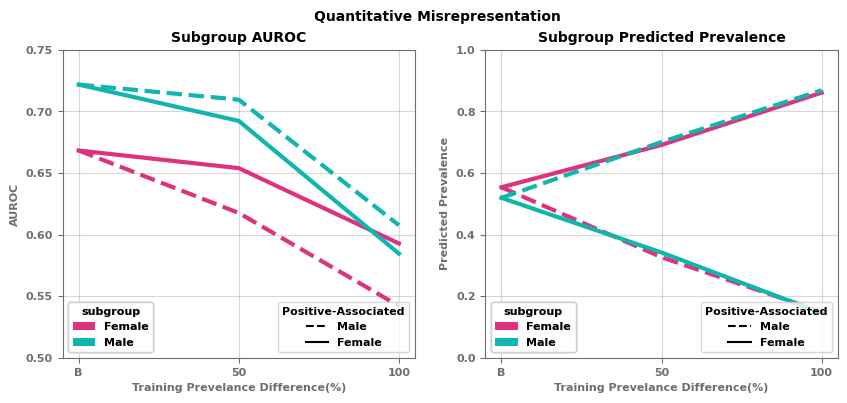


Done



In [10]:
# metric calculation
%run ../src/utils/bias_analysis.py \
    -d "{main_dir}" \
    -e "0FP" "25FP" "50FP" "75FP" "100FP" \
    -a "quantitative misrepresentation" \
    -r "results__.tsv" \
    -i "{main_dir}/independent_test.csv" \
    -s "sex" 